# Inbreeding: When Generative AI Starts Training on Itself

For a folder with output with full training, see this link: [here](https://drive.google.com/drive/folders/1fjXd3oXVgB6QoP9VLyv4XCdtq0hAl-Hz?usp=share_link)



# 1. Introduction and Outline 

Generative models have recently taken the world by storm. ChatGPT and DALL-E are prominent examples of these recent developments. These models are used to generate new text or images which the in return can be found online without any indication that they are generated. Every day, new models are built and these models often rely on information/data found on the internet. In essence, a new model will be partially built on images/data that comes from a generative model. Whether this leads to complications for the model has been, to our knowledge, investigated only once by Alemohammad et al. (2023) which showed that this is a real threat to the development of future generative models. The aim of this project is to further support these findings and investigate whether the use of conditional generative adverserial networks (cGAN) could potentially be limited in the future based on their data. Furthermore, we want to investigate whether this could even imped the ability of building "normal" neural networks as the overall data quality may decrease. The main aim is to show how a GAN can be built and potentially be a cautionary tale about the use of these generative models. 

# 2. Methods

To investigate the idea of a potential collapse of cGANs over many generations, we will use the MNIST dataset which is a common data set in machine learning. The dataset contains a train set of 60.000 hand-written images as well as a test set with 10.000 hand-written images. A conditional deep convolutional generative adverserial network (cDCGAN) will be used. One important note here is that we need the model to be conditional as we want to be able to train over multiple generations meaning that we need the label for each generated image. Our hypothesis will be tested by both visual inspection of each generation as well as the use of a classifier trained on the original data. If the data quality gets worse over time/generation, we would expect to find a continous decrease of classifier accuracy (more about this in the classifier section). 

## Set up
In this section we define central variables, import python libraries, and create folders to store generated data and trained parameters.

### Central Variables

In [1]:
##### Important parameters to adjust in case you want to run it faster
epochs = 1
generations = 10

# Number of new images for each class per generation, 
# this one will increase the speed at which it collapses 
nr_new_images = 250

latent_dim = 100

num_classes = 10
image_size = 28
num_channels = 1

batch_size = 64

### Libraries

In [2]:
# Import
import tensorflow as tf
import time
import numpy as np
import imageio
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten, Input, Concatenate, Dropout
from tqdm.auto import tqdm
from IPython.display import FileLink
from sklearn.model_selection import train_test_split

# Suppress FutureWarning related to use_inf_as_na in seaborn which we can't change. 
# No issues related to this warning, simply annoying to get
# while using it without any effects on the code
warnings.simplefilter(action='ignore', category=FutureWarning)

# Disable Grappler optimizer to aid with tensorflow function (which makes code faster)
tf.config.optimizer.set_experimental_options({"layout_optimizer": False})

# One warning is expected here as there is a more recent version of 
# numpy being used than what SciPy wants to use. 

### Create folders

The code below creates folders on Kaggle to store output. It creates a folder for each part that this model saves: 

* Discriminator 
* Generator 
* Images of a generated 0 - 9 with one image each number
* Selected number of images for a number

In [3]:
def create_folder_if_not_exists(folder_path):
    """
    Create a folder at the specified path if it does not already exist.

    Parameters:
    - folder_path (str): The path of the folder to be created.

    Returns:
    None

    Example:
    >>> create_folder_if_not_exists('/path/to/new_folder')
    """
        
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        
output_dir = '/kaggle/working/output/'
discriminator_dir = os.path.join(output_dir, 'discriminator_models')
generator_dir = os.path.join(output_dir, 'generator_models')
image_same_dir = os.path.join(output_dir, 'same_images')
image_different_dir = os.path.join(output_dir, 'different_numbers')

# Create folders if they don't exist
create_folder_if_not_exists(output_dir)
create_folder_if_not_exists(discriminator_dir)
create_folder_if_not_exists(generator_dir)
create_folder_if_not_exists(image_same_dir)
create_folder_if_not_exists(image_different_dir)

## The MNIST Data Set

The MNIST data set comprises 70k labeled images of handwritten digits from 0 to 9. The images are 28 by 28 pixels and in grayscale.
The train portion consists of 60k images, 6k for each of the 10 classes. The test portion are another 10k images, 1k for each of the 10 classes.
For the GAN training and for the simulation of generations, we will only use the train set. We will train and validate the classifier on the train set, too. However, then we will use the test set to measure the test accuracy of the classifier.


In [4]:
# Load data from keras
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [5]:
# one hot encoding of labels
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [6]:
#Showing the shapes of the MNIST data
print(x_train.shape)
print(y_train.shape)

(60000, 28, 28)
(60000, 10)


GANs work well for images with re-scaled pixel values from -1 to 1 (Preserve Knowledge, 2017). This is why we rescale the MNIST images in the following with code that we adapted from Tensorflow (n.d).

In [7]:
# Scale the pixel values to [-1, 1] range and add a channel dimension to
# the images
x_train = x_train.astype("float32")
x_train = (x_train - 127.5) / 127.5  # Normalize the images to [-1, 1]
x_train = np.reshape(x_train, (-1, 28, 28, 1))

x_test = x_test.astype("float32")
x_test = (x_test - 127.5) / 127.5  # Normalize the images to [-1, 1]
x_test = np.reshape(x_test, (-1, 28, 28, 1))

Finally, we can create a dataset that can be used to build our GAN. 

In [8]:
# Create train tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

We also want to create our data for the classifier which we do in the code below

In [9]:
# MNIST dataset (reloading)

# splitting dataset (20% for validation set)
x_train_cla, x_val_cla, y_train_cla, y_val_cla = train_test_split(x_train, y_train, test_size=0.2)

# train set
dataset_train_cla = tf.data.Dataset.from_tensor_slices((x_train_cla, y_train_cla))
dataset_train_cla = dataset_train_cla.shuffle(buffer_size=1024).batch(batch_size)

# validation set
dataset_val_cla = tf.data.Dataset.from_tensor_slices((x_val_cla, y_val_cla))
dataset_val_cla = dataset_val_cla.shuffle(buffer_size=1024).batch(batch_size)

# test set
dataset_test_cla = tf.data.Dataset.from_tensor_slices((x_test, y_test))
dataset_test_cla = dataset_test_cla.shuffle(buffer_size=1024).batch(batch_size)

# Visualisation Functions

We create the functions for visualisation here as we need them later and they will otherwise interfere with the flow of the code. You can just run them. 

In [10]:
# This cell was written with the help of ChatGPT 

# Visualize one image of each class and save the output file if specified
def vis_one_each(x, y, image_path = None):
    """
    Visualize one image for each digit in the dataset.

    Parameters:
    - x (numpy.ndarray): Input images.
    - y (numpy.ndarray): Corresponding labels for the input images in one-hot encoded format.
    - image_path (str, optional): If provided, the visualization will be saved to the specified file path.

    Returns:
    None

    Example:
    >>> vis_one_each(x_train, y_train, image_path='digit_visualization.png')

    The function iterates through the dataset to find one image for each digit and plots them in a single row.
    The resulting visualization are displayed and can be saved to an image file.
    """
    
    # Create a dictionary to store one image for each digit
    digit_images = {}

    # Iterate through the dataset to find one image for each digit
    for i in range(len(x)):
        digit = y[i].argmax()
        if digit not in digit_images:
            digit_images[digit] = x[i]
        
        if len(digit_images) == 10:  # If we have one image for each digit, break the loop
            break

    # Sort the digit_images dictionary by keys (digits)
    sorted_digit_images = {k: v for k, v in sorted(digit_images.items())}

    # Plot one image for each digit
    fig, axes = plt.subplots(1, 10, figsize=(15, 5))
    for i, (digit, image) in enumerate(sorted_digit_images.items()):
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f'Digit {digit}')
        axes[i].axis('off')

    plt.tight_layout()
        
    if image_path: 
        plt.savefig(image_path)
        
    plt.show()

In [11]:
# This cell was written with the help of ChatGPT
def create_normal_images(class_label, trained_gen, num_images = 2, file_name = "generation_0"):
    """
    Generate and save images using a trained generator for a specified class label.

    Parameters:
    - class_label (int): The class label for which images will be generated.
    - trained_gen: The trained generator model.
    - num_images (int, optional): The number of images to generate. Default is 2.
    - file_name (str, optional): The base name for saving the generated images. Default is "generation_0".

    Returns:
    None

    Example:
    >>> create_normal_images(class_label=5, trained_gen=generator_model, num_images=3, file_name="generated_images")

    Combines random points in the latent space with a one-hot encoded vector representing the class label.
    Generates and saves images with filenames based on the provided 'file_name' parameter.
    """
    
    # Create a one-hot encoded vector for the class label
    class_label_vector = np.zeros(num_classes)
    class_label_vector[class_label] = 1

    # Reshape the one-hot encoded vector to match the rank of random_latent_vectors
    class_label_vector = np.reshape(class_label_vector, (1, -1))

    for num in range(num_images):
        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(1, latent_dim))

        # Combine the latent vectors with the one-hot encoded class label.
        random_vector = tf.concat([class_label_vector, random_latent_vectors], axis=1)

        # Generate an image using the generator.
        generated_image = trained_gen.predict([class_label_vector, random_latent_vectors], verbose = 0)
        
        # Now you have the generated image.
        # Assuming 'generated_image' is a NumPy array
        plt.imshow(generated_image[0, :, :, 0], cmap='gray')  # Assuming the image is grayscale
        plt.axis('off')  # Turn off axis labels
        plt.savefig(file_name + f"image {num}.jpg")
        plt.close() 

In [12]:
# This cell was written with the help of ChatGPT
def generate_and_display_images(input_generator, file_path = None):
    
    """
    Generate and display one image for each class using the given generator.

    Parameters:
    - input_generator: The generator model.

    Returns:
    None

    Example:
    >>> generate_and_display_images(generator_model)

    Uses the provided generator to generate and display images for each class.
    """
    
    image_list = []
    label_list = []
    
    for class_label in range(10):
        
        noise = tf.random.normal(shape=(1, latent_dim))
        label = tf.one_hot([class_label] * 1, num_classes)
        image_generated = input_generator([label, noise])
        
        image_list.append(image_generated)
        label_list.append(label)
    
    x_ready = tf.concat(image_list, axis = 0).numpy()  # Transfor to ndarray for vis_one_each()
    y_ready = tf.concat(label_list, axis = 0).numpy()
    
    if file_path: 
        vis_one_each(x_ready, y_ready, file_path)
        
    else:
        vis_one_each(x_ready, y_ready)

In [13]:
# This cell was written with the help of ChatGPT
def plot_lines(data_list, y_label, title, legend_names=None, save_image = None):
    """
    Plot lines for each inner list in the provided data_list with sequential X-axis values.

    Parameters:
    - data_list (list of lists): List containing data for each line.
    - y_label (str): Label for the Y-axis.
    - title (str): Plot title.
    - legend_names (list, optional): List of names for the legend. Default is None.
    """
    # Set Seaborn style (optional)
    sns.set(style="white")

    # Create a DataFrame from the data_list
    data_df = pd.DataFrame(data_list).T  # Transpose to have each inner list as a column

    # Define line colors
    line_colors = sns.color_palette("husl", n_colors=len(data_df.columns))

    # Plot using Seaborn lineplot with specified line colors and labels
    for i, column in enumerate(data_df.columns):
        sns.lineplot(x=data_df.index, y=data_df[column], color=line_colors[i], label=legend_names[i] if legend_names else None)

    # Set X-axis labels as sequential numbers starting from 0
    plt.xticks(range(0, len(data_df)))
    plt.xlabel("Generations")
    plt.ylabel(y_label)
    plt.title(title)

    # Add legend only if there are two lines and legend_names is provided
    if len(data_df.columns) >= 2 and legend_names:
        plt.legend(loc="best")

        
    if save_image: 
        plt.savefig(save_image)
    # Show the plot
    plt.show()

As we have created all the relevant visualisation functions, we can now visualise 0-9 from the original MNIST data. 

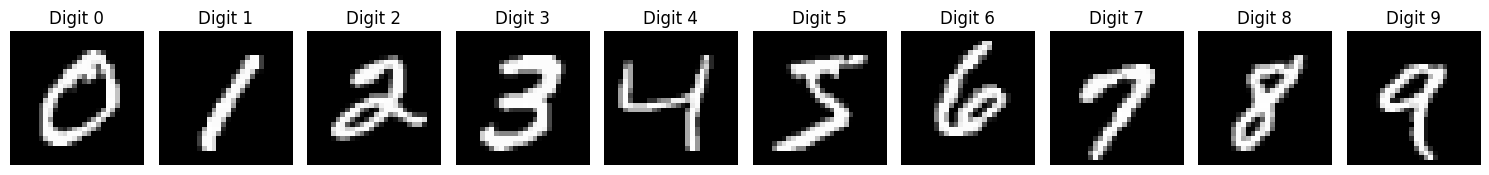

In [14]:
vis_one_each(x_train, y_train)

## cDCGAN: Conditional Deep Convolutional Generative Adversarial Network

The term cDCGAN consists of three terms: first, “conditional” (c), second “deep convolutional” (DC), third “generative adversarial network” (GAN). In the following we explain them briefly in reverse order.

A GAN consists of two networks: a generator and a discriminator (Goodfellow et al., 2014). They are trained in parallel and compete against each other. The goal of the generator is to generate digits which look like the original digits from noise. The goal of the discriminator is to discriminate original digits from digits that were generated by the generator.

The present GAN is a DCGAN because both the generator and the discriminator are multiple convolutional layers deep. The generator uses transposed convolutional layers to upsample the input noise. Features emerge and get increasingly refined to arrive at a coherent image of a digit. The discriminator uses convolutional layers to down-sample an input image and extract features. The representation of the input image gets more and more abstract to arrive at a final binary decision: real digit vs. generated digit.

The present DCGAN is a cDCGAN because both the processing of both networks is conditioned on additional input: the label of the digit (Mirza & Osindero, 2014). The generator learns to not just generate any of the 10 digit classes, but to, e.g., generate a 7 when told to generate a 7. The discriminator in turn, does not just evaluate whether the input image shows a real or a generated image, but conditions its decision on the additional information, that the image shows a 7 (has the label 7).

In the next sections we define and explain the architectures of the generator and discriminator. We also define explain respective loss functions that allow us to train both networks in parallel.

### Generator

The generator consists of the following modules. First, the one-hot encoding label input of length 10 is pre-processed into 10 leakyReLu activations. These are then concatenated with the noise. While it is also possible to concatenate labels and noise right away (Mustapha et al., 2022), we first transform each of the ten elements of the one-hot encoding vector into four embeddings (Preserve Knowledge, 2017) and then flatten them to feed them into a dense layer with ten nodes. This way, the 10 different labels are represented more distinctly and clearly compared to one-hot encoding which makes it easier for the generator to generate distinct digit classes.

The concatenation of pre-processed label and noise is fed into a wide dense layer then reshaped for upsampling (Tensorflow, n.d). This instantiates initial feature traces from which the 10 different digit classes can be upsampled.

Next follow two upsampling layers of decreasing depth but of increasing width and height to arrive at an output layer which yields a tensor of shape 28 x 28 x 1 - the shape of an MNIST image (see Mustapha et al., 2022 for a similar procedure).

We use leakyReLu activations throughout except for the output layer which has tanh activations - a procedure suited for GANs (Preserve Knowledge, 2017). We use dropout layers to avoid overfitting (Srivastava et al., 2014) and batch normalization layers to speed up training (Ioffe & Szegedy, 2015).

In [15]:
def build_generator(label_shape, noise_shape):

    """
    Required inputs
        label_input
            One hot encoding vector of length 10 for MNIST label
            Shape must be defined outside this function = (10, )

        noise_input
            Noise vector of length 100
            Shape must be defined outside this function = (100, )
    """

    # Label input, pre-processing via embeddings & resize back to 10
    label_input = Input(shape = label_shape)
    
    label_embedding = Embedding(10, 4)(label_input)  # Length 10 to 4 embedding dimensions
    label_flattened = Flatten()(label_embedding)
    label_resized = Dense(10)(label_flattened)
    label_norm = BatchNormalization()(label_resized)
    label_activations = LeakyReLU(0.2)(label_norm)

    # Noise input
    noise_input = Input(shape = noise_shape)

    # Combine inputs
    combined_inputs = Concatenate()([label_activations, noise_input])

    # Wide dense layer & reshape for up-sampling
    wide = Dense(7 * 7 * 64)(combined_inputs)
    wide = Dropout(0.3)(wide)
    wide = BatchNormalization()(wide)
    wide = LeakyReLU(0.2)(wide)
    reshaped_wide = Reshape((7, 7, 64))(wide)

    # Up-Sampling 1
    up1 = Conv2DTranspose(
        64, kernel_size = (4, 4), strides = (1, 1), padding = 'same'
        )(
            reshaped_wide  # Input to layer
        )
    up1 = Dropout(0.3)(up1)
    up1 = BatchNormalization()(up1)
    up1 = LeakyReLU(0.2)(up1)
    # Shape should be (7, 7, 128) and maybe there is batch size on top

    # Up-Sampling 2
    up2 = Conv2DTranspose(
        32, kernel_size = (4, 4), strides = (2, 2), padding = 'same'
        )(
            up1  # Input from up1 - yes, up1! not a typo
        )
    up2 = Dropout(0.3)(up2)
    up2 = BatchNormalization()(up2)
    up2 = LeakyReLU(0.2)(up2)
    # Shape should be (14, 14, 64) and maybe there is batch size on top

    # Output
    output_layer = Conv2DTranspose(
        1, kernel_size = (4, 4), strides=(2, 2), padding = 'same', activation = "tanh"
        )(
            up2  # Input from up2
        )
    # Shape should be (28, 28, 1) - like MNIST image

    model = Model(
        inputs = [label_input, noise_input],
        outputs = output_layer,
        name = "generator"
    )

    return model

In the end, the generator model simplified looks like this: 

<a href="https://ibb.co/jkVMJD4"><img src="https://i.ibb.co/7tgWkKy/Generator.png" alt="Generator" border="0"></a>

### Discriminator

We built the discriminator as a roughly reversed generator (see Mustapha, 2022).

The image input is first down-sampled by two convolutional layers of increasing depth but of increasing width and height. Importantly, the down-sampling is regulated via the strides and not through maxpooling layers (Preserve Knowledge, 2017). After flattening, the extracted features of the image are concatenated with pre-processed label input (see Generator section). While it is also possible to concatenate the image input and the label input before down-sampling (Tensorflow, n.d), we decided to do so afterwards which allows for higher-level interaction between extracted features and the pre-processed label (Mustapha, 2022). After a wide dense layer to process features and label, there is a single output node with a sigmoid activation.

Like in the generator we otherwise use leakyReLu activations and also implemented dropout nad batch normalization.

As further explained in the following section, Building the cDCGAN, an activation close to 1 means that the input image is classified as real and an activation close to 0 means that the input image is classified as generated.

In [16]:
def build_discriminator(image_shape, label_shape):
    
    """
    Required inputs
        image_input
            A real or generated MNIST image
            Shape must be defined outside this function = (28, 28, 1)

        label_input
            One hot encoding vector of length 10 for MNIST label
            Shape must be defined outside this function = (10, )
    """
    
    # First downsampling of image
    # Label is added afterwards
    
    image_input = Input(shape = image_shape)
    
    # Down-Sampling 1
    down1 = Conv2D(
        32, kernel_size = (3, 3), strides = (2, 2), padding = "same"
        )(
            image_input  # Input to layer
        )
    down1 = Dropout(0.3)(down1)
    down1 = BatchNormalization()(down1)
    down1 = LeakyReLU(0.2)(down1)

    # Down-Sampling 2
    down2 = Conv2D(
        64, kernel_size = (3, 3), strides = (2, 2), padding = "same"
        )(
            down1  # Input from down1 - yes, down1! not a typo
        )
    down2 = Dropout(0.3)(down2)
    down2 = BatchNormalization()(down2)
    down2 = LeakyReLU(0.2)(down2)

    # Flatten extracted features
    flattened_down2 = Flatten()(down2)
    
    # Label input
    label_input = Input(shape=label_shape)
    
    # Now we pre-process the label_input as in generator
    label_embedding = Embedding(10, 4)(label_input)  # Length 10 to 4 embedding dimensions
    label_flattened = Flatten()(label_embedding)
    label_resized = Dense(10)(label_flattened)
    label_norm = BatchNormalization()(label_resized)
    label_activations = LeakyReLU(0.2)(label_norm)
    
    # Concatenate flattened, extracted features & flattened label representation
    combined_inputs = Concatenate()([flattened_down2, label_activations])

    # Dense layers
    wide = Dense(64)(combined_inputs)
    wide = Dropout(0.3)(wide)
    wide = BatchNormalization()(wide)
    wide = LeakyReLU(0.2)(wide)

    # Output layer
    output_layer = Dense(1, activation="sigmoid")(wide)

    # Define the model
    model = Model(
        inputs=[image_input, label_input],
        outputs=output_layer,
        name="discriminator"
    )
    
    return model

The discriminator model simplified looks like this

<a href="https://ibb.co/CBdJnLY"><img src="https://i.ibb.co/6Yhv4QT/Discriminator.png" alt="Discriminator" border="0"></a>

To see more about the model architecture, check the Appendix. We next want to see whether our model works so we generate some images on a untrained generator and check the output of the untrained discriminator for these images.

In [17]:
# Build generator & discriminator
generator = build_generator(10, 100)
discriminator = build_discriminator([28, 28, 1], 10)

Verify output of **untrained** generator and discriminator

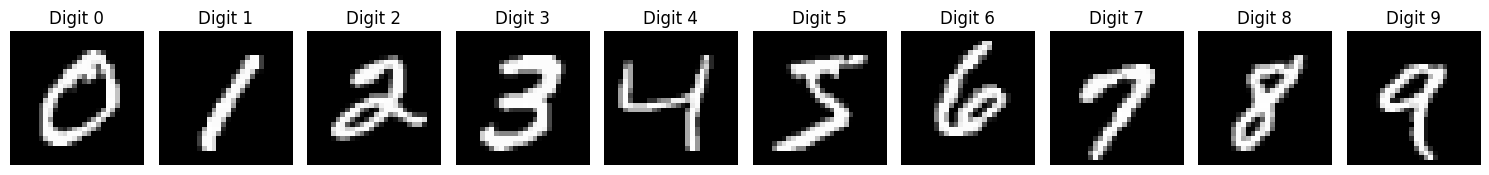

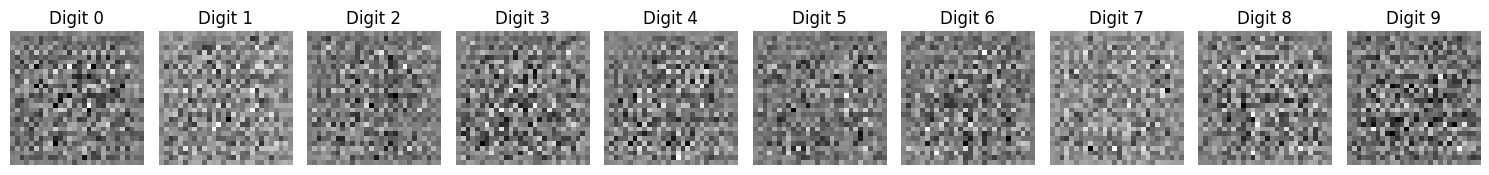

In [18]:
#Generating image of what it should look like
vis_one_each(x_train, y_train)

#Generating image of what the untrained generator shows
generate_and_display_images(generator)

In [19]:
label_class = np.zeros(num_classes)
label_class[9] = 1  # label for digit 9
label_class = np.reshape(label_class, (1, -1)) #Making it compatible with the generator

noise = tf.random.normal([1, 100])
generated_image = generator([label_class, noise])

# This prediciton value should be at around 0.5 as this indicates uncertainty 
# of the discriminator
prediction = discriminator([generated_image, label_class])
print(prediction)

tf.Tensor([[0.50006336]], shape=(1, 1), dtype=float32)


Based on these, we can see that our models are untrained but work as they generate output

### Building the cDCGAN

In the following we define the loss functions for the generator and the discriminator. It is important to note that both loss functions depend on the output of the discriminator. We will first explain the rationale of the discriminator loss.

For each image input, the discriminator either classifies it as real (sigmoid activation close to 1) or as generated (sigmoid activation close to 0). Due to this binary outcome, a binary crossentropy function is an appropriate loss function.

For real images, the discriminator ought to output 1 and so the lower the activation, the higher the loss. However, the discriminator also ought to output 0 for generated images and so the higher the activation, the higher the loss. Therefore, the total discriminator loss is the addition of the loss for real images and the loss for generated images.

We will now explain the rationale of the generator loss. After the generator generates an image, it is evaluated by the discriminator. The discriminator will be successful if it outputs a low sigmoid activation for this generated image. However, the generator will be successful, if the discriminator outputs a high sigmoid activation and thus mistakenly classifies the generated image as real. Therefore, the higher the sigmoid activation, the more real does the generated image seem to the discriminator. So, the lower the sigmoid activation, the higher the generator loss.

To summarize, the discriminator tries to maximize the the sigmoid activation for real images and tries to minimize the activation for generated images. But the generator tries to maximize the sigmoid activation for generated images. And so the two compete and, ideally, their losses converge or at least stay roughly similar.

We chose adam optimizers for both networks as recommended for GANs (Preserved Knowledge, 2017).
The code for cross_entropy(), discriminator_loss(), generator_loss(), and optimizers is adapted from Tensorflow (n.d.).

In [20]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

# Discriminator Loss
def discriminator_loss(real_output, fake_output):
    """
    Compute the discriminator loss based on real and fake outputs.

    Parameters:
    - real_output: Output from the discriminator for real samples.
    - fake_output: Output from the discriminator for fake/generated samples.

    Returns:
    - total_loss: Combined discriminator loss.

    Example:
    >>> loss = discriminator_loss(real_outputs, fake_outputs)

    The function uses cross-entropy loss, considering 1 for real and 0 for fake.
    """
    
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)  # 1 is real, 0 is fake
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Generator Loss
def generator_loss(fake_output):
    """
    Compute the generator loss based on fake output.

    Parameters:
    - fake_output: Output from the discriminator for fake/generated samples.

    Returns:
    - loss: Generator loss.

    The function uses cross-entropy loss, treating fake outputs as real for training the generator.
    """
        
    return cross_entropy(tf.ones_like(fake_output), fake_output)  # misleading labels

# Define optimizers
generator_optimizer = tf.keras.optimizers.legacy.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.legacy.Adam(1e-4)

In the following we define the train_step() function which we adapted from Tensorflow (n.d.). For each batch of real images we create the same amount of generated images with identical labels. Then, the discriminator makes predictions for both the real and generated images. Both predictions are used to calculate the discriminator loss. Only the predictions for the generated images are used to calculate the generator loss.

We do have to use a trick here that may not be optimal but allows the code to run a lot faster. By defining a function within a function, we can re-build the train_step function for each generation. There are otherwise issues related to the definition of variables within a tensorflow function so this was a fast & easy fix which may not be perfectly in line with coding conventions. 

In [21]:
def set_up_new_train_step():
    @tf.function
    def train_step(data, generator, discriminator, noise):
        """
        Perform one training step for the GAN model.

        Parameters:
        - data: Batch of original MNIST images and labels.
        - generator: Generator model.
        - discriminator: Discriminator model.

        Returns:
        - gen_loss: Generator loss.
        - disc_loss: Discriminator loss.

        Example:
        >>> gen_loss, disc_loss = train_step(data_batch, generator_model, discriminator_model)

        This function executes a single training step for a GAN model using the provided generator and discriminator.
        It calculates and applies gradients to update the generator and discriminator weights based on adversarial losses.
        """

        # Get original MNIST images
        images_real, labels_real = data

        # Create noise for generator
        #batch_size = tf.shape(images_real)[0]
        #noise = tf.random.normal(shape=(batch_size, latent_dim))
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

            # Generate images from noise
            labels_generated = labels_real
            images_generated = generator([labels_generated, noise], training = True)

            # Disc Predictions for real & generated images
            predictions_real = discriminator([images_real, labels_real], training = True)
            predictions_generated = discriminator([images_generated, labels_generated], training = True)

            # Compute loss for generator & discriminator
            gen_loss = generator_loss(predictions_generated)
            disc_loss = discriminator_loss(predictions_real, predictions_generated)

        # Calculate gradients based on losses
        grads_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(grads_generator, generator.trainable_variables))

        # Update weights
        grads_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(grads_discriminator, discriminator.trainable_variables))

        return gen_loss, disc_loss
    
    return train_step

Next, we define the train() function which we adapted from Tensorflow (n.d). During training, it per epoch provides: training time, generator loss, and discriminator loss.

In [22]:
def train(dataset, epochs, generator, discriminator):
    """
    Train a GAN model for a specified number of epochs.

    Parameters:
    - dataset: Training dataset.
    - epochs (int): Number of training epochs.
    - generator: Generator model.
    - discriminator: Discriminator model.

    Returns:
    - generator: Trained generator model.
    - discriminator: Trained discriminator model.

    Example:
    >>> trained_gen, trained_disc = train(training_data, num_epochs, generator_model, discriminator_model)

    This function trains a GAN model for the specified number of epochs using the provided generator and discriminator.
    """
    #This is a for loop for the range of epochs
    for epoch in tqdm(range(epochs)):
        # We set the generator & discriminator loss here
        generator_loss = 0.0
        discriminator_loss = 0.0
        
        # As the dataset as a whole would be too big, we uses batches for training
        for image_batch in dataset:
            # As the last batch may not be the same size as the previous ones 
            # but we need the noise to be of similar dimension, we generate noise 
            # with the same length as the batch size for each batch
            batch_size_specific = tf.shape(image_batch[0])[0] 

            # Generate noise with the current batch size
            noise = tf.random.normal(shape=(batch_size_specific, latent_dim))
            
            # One training step
            gen_loss, disc_loss = train_step(image_batch, generator, discriminator, noise)
            
            # Adding the generator loss and discriminator loss
            generator_loss += gen_loss
            discriminator_loss += disc_loss
        
        # This divides the loss by the number of batches which is useful to have 
        # over multiple generations to see the performance of the model. 
        
        generator_loss /= len(dataset)
        discriminator_loss /= len(dataset)
        
        generator_loss = round(float(generator_loss), 2)
        discriminator_loss = round(float(discriminator_loss), 2)
        
    return generator, discriminator, generator_loss, discriminator_loss

Finally, it is time to train the first generation. The code trains the model for the specified number of epochs in the first code cell and then saves the model. Additionally, it shows images created by the trained generator and from the original dataset for comparison. 

  0%|          | 0/1 [00:00<?, ?it/s]

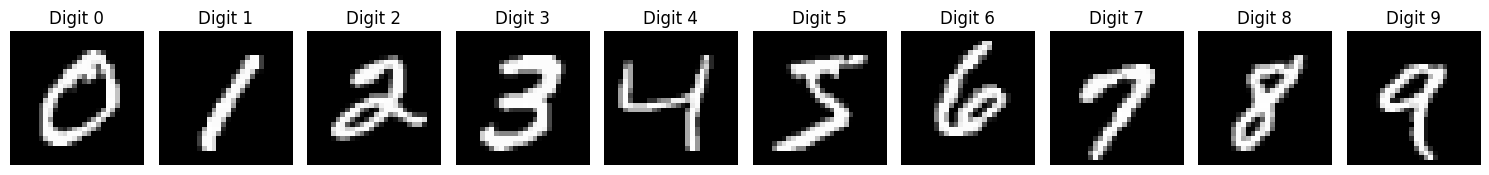

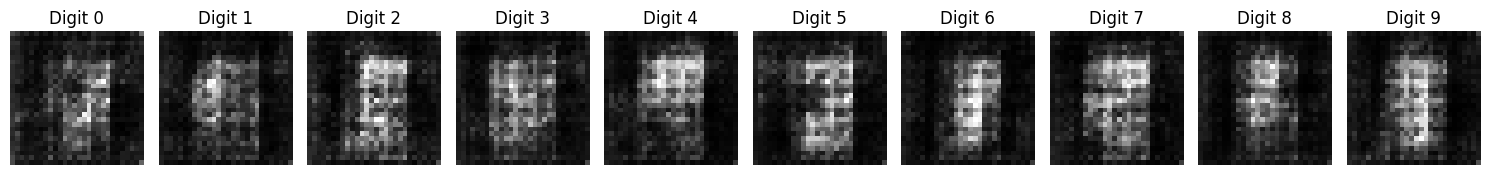

In [23]:
#Using the previously mentioned trick, we define a new train_step function here
train_step = set_up_new_train_step()

#Training on the data
trained_gen, trained_disc, generator_loss_value, discriminator_loss_value = train(dataset, epochs, generator, discriminator)

# Save the generator
trained_gen.save("/kaggle/working/output/generator_models/generator_model_gen_1.keras")

# Save the discriminator
trained_disc.save("/kaggle/working/output/discriminator_models/discriminator_model_gen_1.keras")

# Create images from train set to compare to generator
vis_one_each(x_train, y_train)

# Create images from generator 
generate_and_display_images(trained_gen, "/kaggle/working/output/different_numbers/different_num_gen_1.jpg")

Now that we have finished training the first generation of our generative model, it is time to think more about the way we can test the decreasing quality of these models as we train them over generations. We will visually inspect the output of the generations but we also want to use a different measure. 

## Classfier

Thus, in order to more systematically assess the performance of the generator / generated images, we used a classifier that we trained ourselves. Using a classifier instead of eyeballing provides us with a more empirical and quantitative metric to judge and assess the diminishing quality of our generated images. Extracting the classifier accuracy per generation allows to succinctly achieve this goal of ours, and better compare images generated across generations. 

#### Classifier Architecture

The classifier was trained on 80% of the MNIST training dataset and validated using 20% of the original train dataset. The classifier model architecture is that of a convolutional neural net, consisting of layers similar to our generator and discriminator (such as the dropout and batch normalisation). More specifically, our classifier consists of 3 convolutional layers, with dropout, batch normalisation and max pooling. Thereafter, we flatten the layers and add dense layers. 

In [24]:
def build_classifier():
    classifier = models.Sequential()

    classifier.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    #classifier.add(layers.Dropout(0.3))
    classifier.add(layers.BatchNormalization())
    classifier.add(layers.MaxPooling2D((2, 2)))

    classifier.add(layers.Conv2D(32, (3, 3), activation='relu'))
    #classifier.add(layers.Dropout(0.3))
    classifier.add(layers.BatchNormalization())
    classifier.add(layers.MaxPooling2D((2, 2)))

    classifier.add(layers.Conv2D(64, (3, 3), activation='relu'))
    classifier.add(layers.BatchNormalization())

    classifier.add(layers.Flatten())
    #classifier.add(layers.Dropout(0.3))
    classifier.add(layers.Dense(64, activation='relu'))
    classifier.add(layers.BatchNormalization())

    classifier.add(layers.Dense(10, activation='softmax'))
    
    return classifier

#### Optimizer & Loss

To maintain consistency, we used the same recommended optimiser (Adam) as our GAN and aim to minimise the categorical cross entropy loss, since we have multiple classes (10, for each number in the MNIST dataset). We also train the classifier in the code cell below. 

In [25]:
classifier = build_classifier()

# Compile and train 
classifier.compile(
    optimizer ='adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

# Training classifier
history = classifier.fit(
    dataset_train_cla,
    validation_data = dataset_val_cla,
    epochs = 20,
    verbose = 0,
    batch_size = 64)

Lastly, we can evaluate the accuracy on the test set to see how well our model is doing. We print the loss and accuract as well as saving the final model which we then use again later in the final step

In [26]:
# now check performance on dataset_test
test_loss, test_accuracy = classifier.evaluate(dataset_test_cla, verbose=0)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Saving the classifier so we can easily import it later
classifier.save("/kaggle/working/output/classifier_MNIST.keras")

Test Loss: 0.03915620967745781
Test Accuracy: 0.9904000163078308


### Create Dataset of Next Generation

The code below here can be used to generate new data with a generator. It creates a new image num_samples time (see first code cell) for each number in the MNIST (0-9). If num_samples = 100, it will generate 1000 new images (100 for each number) 

In [27]:
def generate_new_images_dataset(num_samples, trained_gen, num_classes=10, latent_dim=100, batch_size=batch_size):
    # Initialize lists to store your dataset
    all_digits = []
    all_labels = []

    # Generate images and labels and add them to the dataset
    for your_class_label in range(num_classes):
        # Create a one-hot encoded vector for the class label
        class_label_vector = np.zeros(num_classes)
        class_label_vector[your_class_label] = 1  # Set the corresponding index to 1

        # Reshape the one-hot encoded vector to match the rank of random_latent_vectors
        class_label_vector = np.reshape(class_label_vector, (1, -1))

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(num_samples, latent_dim))

        # Combine the latent vectors with the one-hot encoded class label.
        random_vector = tf.concat([random_latent_vectors, class_label_vector.repeat(num_samples, axis=0)], axis=1)

        # Generate a batch of images using the generator.
        generated_images = trained_gen.predict([class_label_vector.repeat(num_samples, axis=0), random_latent_vectors], verbose=0)

        # Reshape the generated images
        generated_images = np.reshape(generated_images, (num_samples, 28, 28, 1))

        # Append the generated images and their one-hot encoded labels to the lists
        all_digits.append(generated_images)
        all_labels.append(np.full((num_samples,), your_class_label))

    # Convert the lists to NumPy arrays
    images = np.concatenate(all_digits, axis=0)
    labels = np.concatenate(all_labels, axis=0)

    all_digits = images.astype("float32") / 255.0

    # Create tf.data.Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((all_digits, keras.utils.to_categorical(labels, 10)))
    dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

    return dataset, images, labels


## The Final Loop

We started by creating the dataset, training the generator & discriminator, and generated new images. We additionally built the clasifier we need to see the performance of the model. In the last step, we now need to replace 250 images randomly and create the loop to investigate out question. For a visual description of our procedure, see the image below.

<a href="https://ibb.co/gjyZR3t"><img src="https://i.ibb.co/NVx2ysW/Procedure.png" alt="Procedure" border="0"></a>

  0%|          | 0/10 [00:00<?, ?it/s]

This is Generation: 1
Generating New Images
Test Accuracy:  0.09679999947547913
Training on New Data


  0%|          | 0/1 [00:00<?, ?it/s]

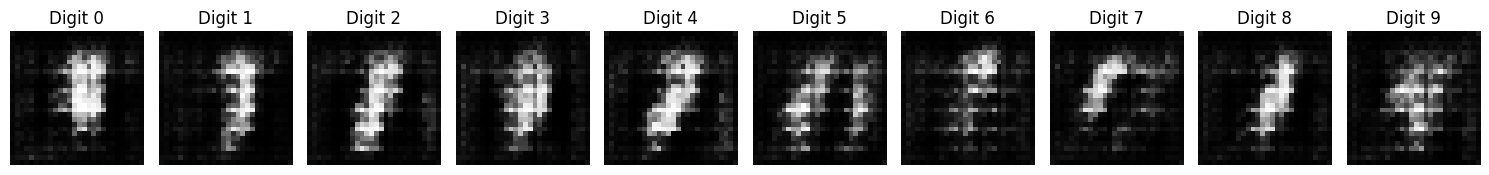

This is Generation: 2
Generating New Images
Test Accuracy:  0.10080000013113022
Training on New Data


  0%|          | 0/1 [00:00<?, ?it/s]

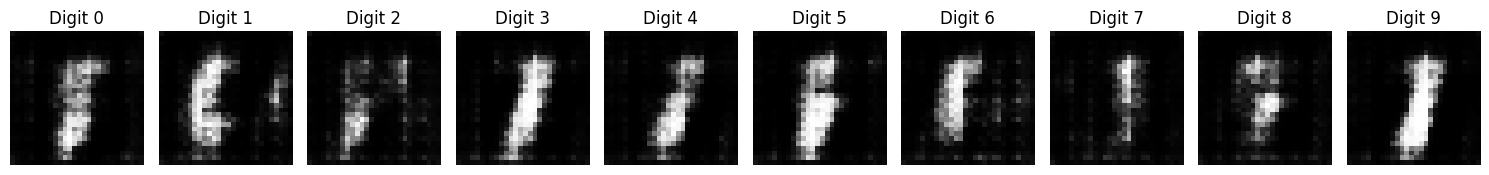

This is Generation: 3
Generating New Images
Test Accuracy:  0.09239999949932098
Training on New Data


  0%|          | 0/1 [00:00<?, ?it/s]

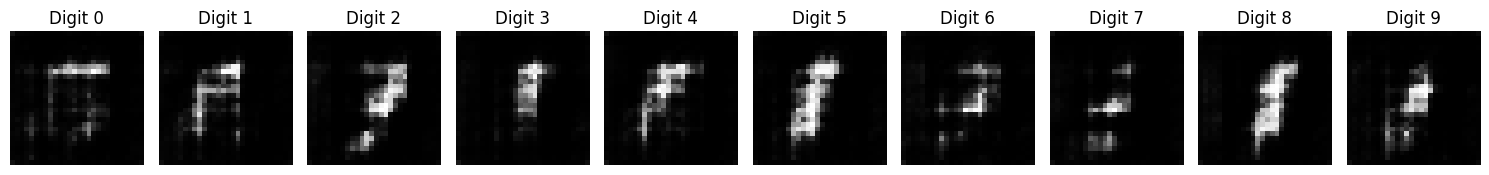

This is Generation: 4
Generating New Images
Test Accuracy:  0.09719999879598618
Training on New Data


  0%|          | 0/1 [00:00<?, ?it/s]

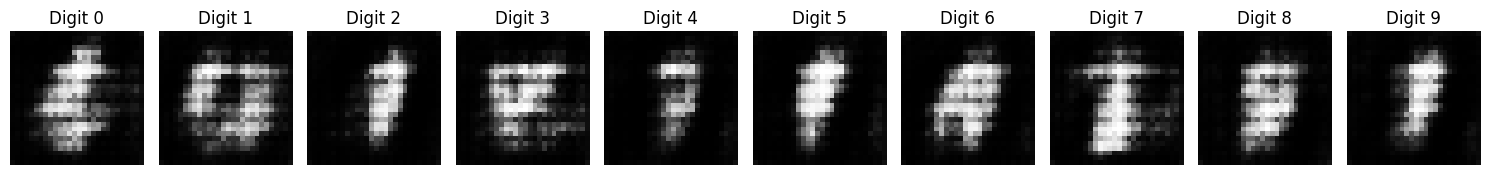

This is Generation: 5
Generating New Images
Test Accuracy:  0.12240000069141388
Training on New Data


  0%|          | 0/1 [00:00<?, ?it/s]

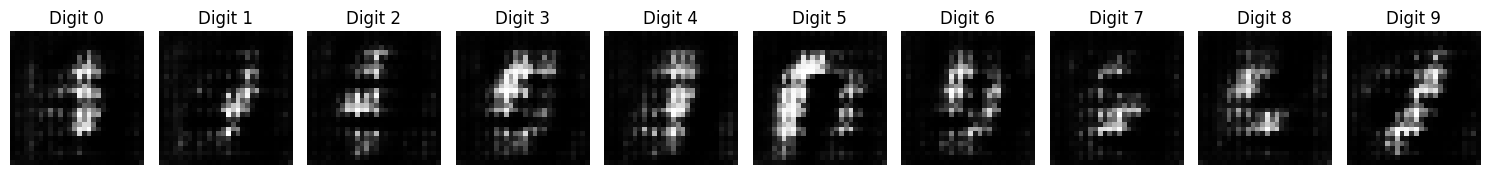

This is Generation: 6
Generating New Images
Test Accuracy:  0.09719999879598618
Training on New Data


  0%|          | 0/1 [00:00<?, ?it/s]

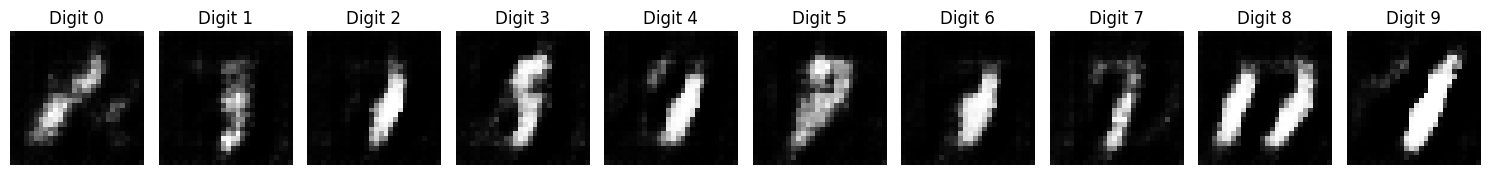

This is Generation: 7
Generating New Images
Test Accuracy:  0.09839999675750732
Training on New Data


  0%|          | 0/1 [00:00<?, ?it/s]

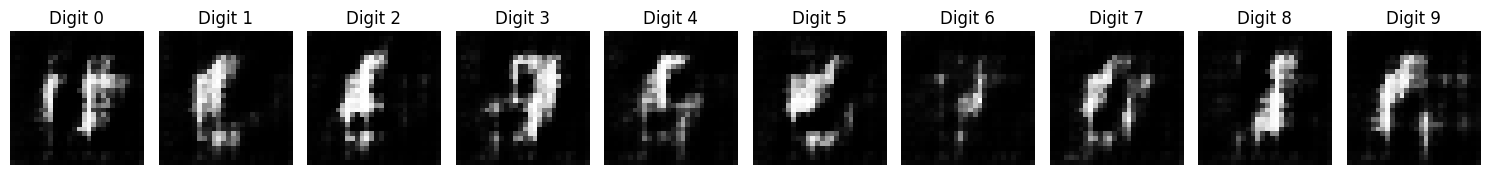

This is Generation: 8
Generating New Images
Test Accuracy:  0.09679999947547913
Training on New Data


  0%|          | 0/1 [00:00<?, ?it/s]

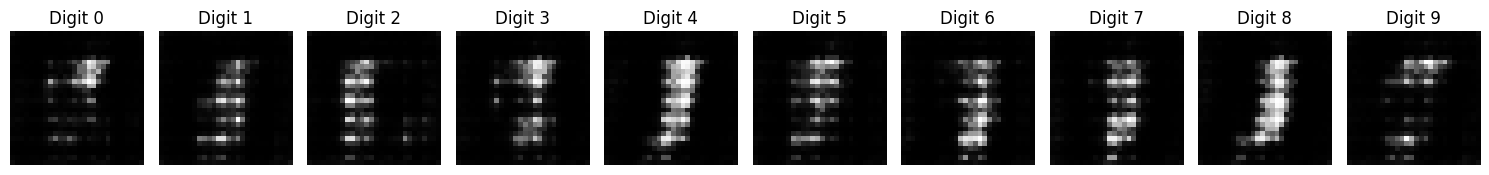

This is Generation: 9
Generating New Images
Test Accuracy:  0.1111999973654747
Training on New Data


  0%|          | 0/1 [00:00<?, ?it/s]

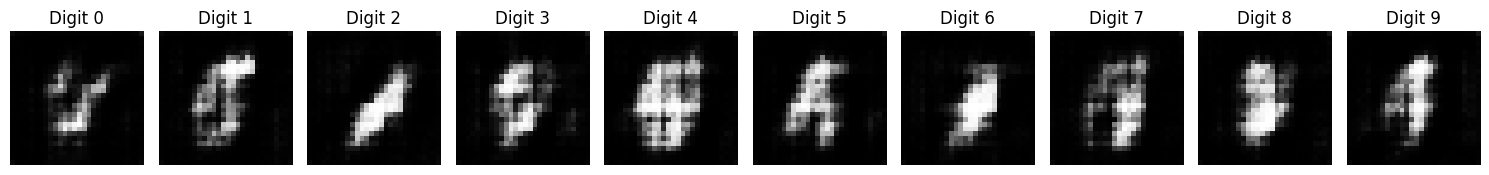

This is Generation: 10
Generating New Images
Test Accuracy:  0.08839999884366989
Training on New Data


  0%|          | 0/1 [00:00<?, ?it/s]

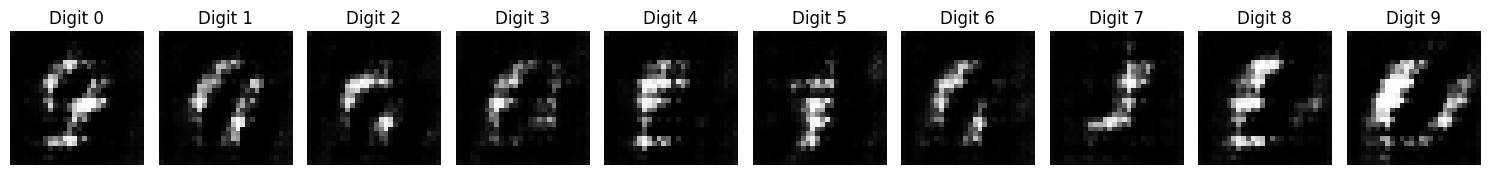

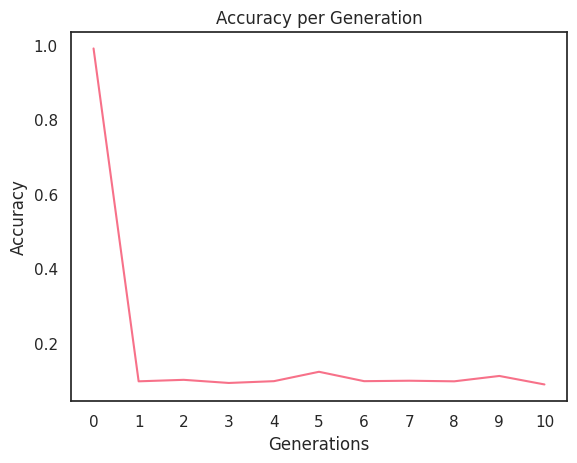

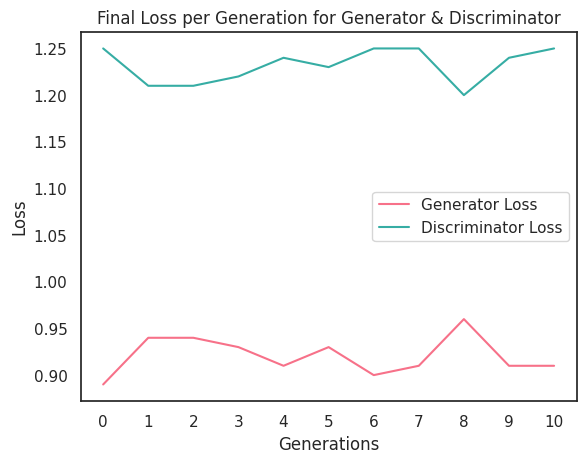

In [30]:
# This code assumes that you ran all the cells above and have an existing model

# Creating the lists to save the test_loss and test_accuracy. 
# Includes the classifier at the first stage to establish a baseline
classifier_loss = [test_loss]
classifier_accuracy = [test_accuracy]
list_generator_loss = [generator_loss_value]
list_discriminator_loss = [discriminator_loss_value]

# Load the previous classifier
classifier = tf.keras.models.load_model("/kaggle/working/output/classifier_MNIST.keras")

# A for loop over the number of generations decided in the first cell
for generation in tqdm(range(generations)):
    # Related to the use of Keras functions
    tf.keras.backend.clear_session()
    
    print(f"This is Generation: {generation + 1}")
    
    # Loading the last trained generator. We start at this point of the loop 
    # as we have already trained the first version above
    trained_gen = tf.keras.models.load_model(f'/kaggle/working/output/generator_models/generator_model_gen_{generation + 1}.keras')
    
    # Generating a new dataset. We do not use the actual dataset created as we need to 
    # adjust some things and the data was easier to use for our purpose this way
    
    print("Generating New Images")
    _, x_generated, y_generated = generate_new_images_dataset(nr_new_images, trained_gen)
    
    #One_hot encode for classifier
    y_generated_cla = keras.utils.to_categorical(y_generated, 10)
    
    #Replacement loop for the MNIST data
    for digit in range(10):  
        # Finding the indices where the generated data is equal to the digit of the loop
        digit_indices = np.where(y_generated == digit)[0][:nr_new_images]
        
        #Randomly selecting nr_new_images from the dataset
        indices_to_replace = np.random.choice(np.where(y_train[:, digit] == 1)[0], size=nr_new_images, replace=False)
        
        #Replacing the randomly selected images with the generated images
        
        x_train[indices_to_replace] = x_generated[digit_indices]
        x_train[indices_to_replace] = x_generated[:nr_new_images]

    # Create tf.data.Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)
    
    #Getting the accuracy & loss from the classifier
    test_loss, test_acc = classifier.evaluate(x_generated, y_generated_cla, verbose = 0)
    
    #Appending to the datasets
    classifier_accuracy.append(test_acc)
    classifier_loss.append(test_loss)
    print("Test Accuracy: ", test_acc)
    
    # Building a new untrainted generator & discriminator
    generator = build_generator(10, 100)
    discriminator = build_discriminator([28, 28, 1], 10)
    
    print("Training on New Data")
    
    #Using the previously mentioned trick to create a new version of the train_step 
    #function
    train_step = set_up_new_train_step()
    
    #Train on the new dataset
    trained_gen, trained_disc, generator_loss_value, discriminator_loss_value = train(dataset, epochs, generator, discriminator)

    #Append the last loss of both models so we can investigate their performance over time
    list_generator_loss.append(generator_loss_value)
    list_discriminator_loss.append(discriminator_loss_value)
    
    # Save the generator to the specified directory
    trained_gen.save(os.path.join(generator_dir, f"generator_model_gen_{generation + 2}.keras"))

    # Save the discriminator to the specified directory
    trained_disc.save(os.path.join(discriminator_dir, f"discriminator_model_gen_{generation + 2}.keras"))

    # Visualizations
    # Generate one image for each class and save it
    generate_and_display_images(trained_gen, os.path.join(image_different_dir, f"different_num_gen_{generation + 2}.jpg"))

    # Save normal images to the specified directory
    create_normal_images(1, trained_gen, file_name=os.path.join(image_same_dir, f"generation_{generation + 2}"))

#Once the loop is finished, create a graph for the accraucy and save it
plot_lines([classifier_accuracy], "Accuracy", "Accuracy per Generation", None, os.path.join(output_dir, "Accuracy_graph.jpg"))

# Create the graph showing generator and discriminator losses over generation
# We expect to find higher generator losses after some generations 
plot_lines([list_generator_loss, list_discriminator_loss], "Loss", 
           "Final Loss per Generation for Generator & Discriminator",
          ["Generator Loss", "Discriminator Loss"], os.path.join(output_dir, "Loss_graph.jpg"))

Based on these results, we were further interested in how these newly generated images would not only limit the building/training of new generative models but also potential issues for other machine learning approaches. We investigate this by building a classifier using the last dataset with the defined number of generated images. 

In [31]:
# As we have modified the x_train/y_train in the code cell above, we can now use it for 
# our train - validation split
x_train_cla_gen, x_val_cla_gen, y_train_cla_gen, y_val_cla_gen = train_test_split(x_train, y_train, test_size=0.2)

# train set
dataset_train_cla_gen = tf.data.Dataset.from_tensor_slices((x_train_cla_gen, y_train_cla_gen))
dataset_train_cla_gen = dataset_train_cla_gen.shuffle(buffer_size=1024).batch(batch_size)

# validation set
dataset_val_cla_gen = tf.data.Dataset.from_tensor_slices((x_val_cla_gen, y_val_cla_gen))
dataset_val_cla_gen = dataset_val_cla_gen.shuffle(buffer_size=1024).batch(batch_size)

classifier_gen = build_classifier()

# Compile and train 
classifier_gen.compile(
    optimizer ='adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

# Training classifier
history_gen = classifier_gen.fit(
    dataset_train_cla_gen,
    validation_data = dataset_val_cla_gen,
    epochs = 20,
    verbose = 0,
    batch_size = 64)

We have now built the classifier on the data after the last generation, let's see how it performs on the original test set

In [32]:
# now check performance on dataset_test
test_loss, test_accuracy = classifier_gen.evaluate(dataset_test_cla, verbose=0)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

Test Loss: 0.0367075577378273
Test Accuracy: 0.9886999726295471


We now have all the results that we want! We will discuss/show our results in the section below. The last line of code can be used to create a zip file of the output folder for the ease of download

In [ ]:
!zip -r file.zip /kaggle/working
FileLink(r'file.zip')

# 4. Results

The first step in our analysis was to look at the visual output for each generation and check the quality visually. Based on the differences between generation 1 and generation 10, we can clearly see that there is a decrease in performance of the cGAN. The more generations we had, the worse the images got. Interstingly, numbers containing a loop such as "8" were actually turned often into just one loop similar to "0". Simpler numbers such as "1" were still stable after generation 10 indicating that they may be more robust to these changes given their simplicity. 

Looking into the classifier accuracy, we can further support these results. The classifier accuracy on the test set was 99%. For generation 1, the accuracy of our classifier was at 97% followed by 95% in the second generation. However, in the last generation, we were at an accuracy of around 65%. At generation 10, the maximum replacement was 2500 images per class/number with still a minimum of 3500 original images left. For more detail about this, check the figure below. 

<a href="https://ibb.co/vVJdBKg"><img src="https://i.ibb.co/Qp6Hc1z/Accuracy-graph.jpg" alt="Accuracy-graph" border="0"></a>

Concerning the losses of the generator and discriminator, while there is some discrepancy between the two losses, they remain in the same magnitude across generations. Based on this metric of model diagnostics, we can infer that the training procedure and the model progress quite similar across sthe generations

Therefore, the decrease in classification accuracy should rather stem from the training data that changes and not because of some incompatibilty of our design/approach in later generations. See figure below for more visualisation about this. 

<a href="https://ibb.co/9YQTssB"><img src="https://i.ibb.co/7ysW22B/Loss-graph.jpg" alt="Loss-graph" border="0"></a>

Lastly, we can look into the performance of our classifier trained on the data after the last generation. We can see that the performance on the test set is 62% compared to the 99% of the classifier trained on the original data. 

# 5. Conclusion / Discussion (max. 300 words)

Our results show that the use of generative models can lead to issues for future models not only for generative models but also other machine learning models. One potential limitation of our approach is that we used rather simplistic images with the MNIST dataset. However, based on our finding that complex number deteriorate faster compared to simple images, we argue that the effects of generations would effect more complex images even more. 

The model can be improved further by repeating the process with a different dataset and by optimising the structure of the models further. By using a different dataset, our findings could be further supported and allow for more generalizability. As an example, one could use the natural scenes dataset or the imagenet dataset and investigate the effect further. Additionally, the may be a structure that increases the quality of the generated images even further. Our generated images in generation 1 look good and the classifier does have high accuracy but there could still be more suited structures. 

The results found should not be interpreted in a very negative sense but more as a cautionary tale for the potential issues in relation to the use of generative models. Only using data pre large scale generative models (e.g. only data from 2013), while being a working solution, is not a effective solution. Progress in terms of image quality and other instances will eventually happen. As an example, if you want colour TV, you can't stick with material available for building a black & white TV. Using the most recent data will be important to build accurate and useable models. Instead, one should pay attention to what images are fed into the model and be aware of the downsides of using generated images within your training data. Additionally, we could think about ways allowing to distinguish between real and generated images. Based on our results, generative models do eventually decrease in quality if trained on themselves but we hope that the results serve as a cautionary tale.

# 6. References

Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., ... & Bengio, Y. 
(2014). Generative adversarial nets. *Advances in neural information processing systems*, *27*.

Ioffe, S., & Szegedy, C. (2015). Batch normalization: Accelerating deep network training by 
reducing internal covariate shift. *International conference on machine learning* (pp. 448-456).

Mirza, M., & Osindero, S. (2014). Conditional generative adversarial nets. *arXiv preprint arXiv:1411.1784*.

Mustapha, I. B., Hasan, S., Nabus, H., & Shamsuddin, S. M. (2022). Conditional deep convolutional generative adversarial networks for isolated handwritten arabic character generation. *Arabian Journal for Science and Engineering*, *47*(2), 1309-1320.

Preserve Knowledge. (2017, August 25). *How to train a GAN, NIPS 2016 | Soumith Chintala, Facebook AI Research* [Video]. YouTube. https://www.youtube.com/watch?v=myGAju4L7O8

Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: a
 simple way to prevent neural networks from overfitting. *The journal of machine learning research*, *15*(1), 1929-1958.

*TensorFlow*. (n.d.). Deep Convolutional Generative Adversarial Network. https://www.tensorflow.org/tutorials/generative/dcgan

# 7. Contributions

Vincent Ott: re-scaling of images; vis_one_each(); generate_and_display_images(); build_generator(); build_discriminator; building the cDCGAN; explanation of cDCGAN architecture, losses, and training procedure; Help with poster and writing

Florian Burger: General code flow & code efficieny, generation of new data, final loop, assisting in discriminator, generator, cDCGAN, generate lines, smaller fixes within code. Help with Poster and writing

Nityah Shah: Classifier, generation of new data, assisting in discriminator, generator, and cDCGAN. Additionally, majority of writing and poster presentation

# 8. Appendix

The code cells below can be used to see more information about the generator and discriminator

In [33]:
# Build generator & discriminator
generator = build_generator(10, 100)
discriminator = build_discriminator([28, 28, 1], 10)

In [ ]:
generator.summary()

In [ ]:
tf.keras.utils.plot_model(generator, show_shapes = True)

In [ ]:
discriminator.summary()

In [ ]:
tf.keras.utils.plot_model(discriminator, show_shapes = True)